#Objectif : Nombre d'arrêtés par département par mois et par niveau d'alerte

In [148]:
import os
from dotenv import load_dotenv
from pathlib import Path
import geopandas as gpd
from datetime import datetime
import pandas as pd
import json
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import requests
from matplotlib.patches import Patch
import locale




%matplotlib inline

In [149]:
#dossier de stockage des fichiers geojson
# Chargement des variables d'environnement
load_dotenv()
STORAGE_DIR = os.getenv("STORAGE_DIR")

# Définir la locale en français
locale.setlocale(locale.LC_TIME, 'fr_FR.UTF-8')

'fr_FR.UTF-8'

In [6]:
def recuperation_fichiers_geojson(mois,annee,dossier_stockage):
    """
    Fonction pour récupérer les fichiers geojson d'un mois et d'une année donnés
    dans le dossier de stockage.
    """
    #récupération des fichiers geojson dans le dossier de stockage
    # Parcourir tous les fichiers du dossier
    # Chemin vers le dossier de stockage
    STORAGE = Path(dossier_stockage)

    # Dictionnaire pour stocker les DataFrames (clé = nom du fichier, valeur = DataFrame)
    dataframes = {}

    for file in STORAGE.iterdir():
        # 1. Vérifier si le fichier est un GeoJSON (extension .json ou .geojson)
        if file.suffix.lower() in [".json", ".geojson"]:
            print(f"Fichier trouvé : {file.name}")

            # 2. Récupérer les métadonnées du fichier pour la date de création
            stat = file.stat()

            # 3. recupération de la date contenu dans le nom du fichier
            date_telechargmement_str = file.stem.split('_')[-1]  # Extraction de la partie date
            date_telechargmement = datetime.strptime(date_telechargmement_str, "%Y-%m-%d").date() # Conversion en objet datetime
            print(f"Date extraite du nom de fichier : {date_telechargmement}")
            annee_telechargement = date_telechargmement.year
            #print(f"Année de téléchargement : {annee_telechargement}")
            mois_telechargement = date_telechargmement.month
            #print(f"Mois de téléchargement : {mois_telechargement}")
            jour_telechargement = date_telechargmement.day
            #print(f"Jour de téléchargement : {jour_telechargement}")
            
            # 4. Filtrer par mois et année
            if annee_telechargement != annee or mois_telechargement != mois:
                print(f"Ignoré : le fichier {file.name} ne correspond pas au mois {mois} et à l'année {annee}.\n")
                continue

            # 5. Lire le fichier GeoJSON avec GeoPandas
            gdf = gpd.read_file(file)
            # Ajouter une colonne avec la date de téléchargement
            gdf["date téléchargement"] = date_telechargmement
            #display(gdf.head())
            # Convertir colonnes str en dictionnaire : 'arreteRestriction' et 'departement'
            colonnes_dict = ['arreteRestriction', 'departement']
            for col in colonnes_dict:
                if col not in gdf.columns:
                    print(f"Attention : la colonne '{col}' est absente dans le fichier {file.name}.")
                else:
                    gdf[col] = gdf[col].apply(
                lambda x: json.loads(x.replace(r'\/', '/')) if isinstance(x, str) else x
            )
            # normaliser les colonnes de type dictionnaire en colonnes plates       
            arrete_df = pd.json_normalize(gdf['arreteRestriction']).add_prefix('arrete_')
            #display(arrete_df.head())
            departements_df = pd.json_normalize(gdf['departement']).add_prefix('departement_')
            #display(departements_df.head())
            gdf = pd.concat([gdf, arrete_df, departements_df], axis=1).drop(columns=['arreteRestriction', 'departement'])
            gdf.to_csv(f"export_data/{file.stem}.csv", index=False, encoding='utf-8-sig')
            

            # 5. Afficher les infos : nom, date de création, nombre de géométries
            print(f"--- Fichier: {file.name} ---")
            # print(f"Date de création : {date_creation}")
            # print(f"Date de modification : {date_modification}")
            print(f"Nombre de géométries : {len(gdf)}\n")

            

            # Stocker le DataFrame dans le dictionnaire avec le nom du fichier comme clé
            dataframes[file.stem] = gdf  # file.stem = nom du fichier sans extension

            # Afficher un résumé
            print(f"DataFrame '{file.stem}' créé avec {len(gdf)} géométries.\n")
    return dataframes


In [7]:
dfs = recuperation_fichiers_geojson(mois=1, annee=2026, dossier_stockage=STORAGE_DIR)


Fichier trouvé : fichier_geojson_2026-01-14.json
Date extraite du nom de fichier : 2026-01-14
--- Fichier: fichier_geojson_2026-01-14.json ---
Nombre de géométries : 110

DataFrame 'fichier_geojson_2026-01-14' créé avec 110 géométries.

Fichier trouvé : fichier_geojson_2026-01-15.json
Date extraite du nom de fichier : 2026-01-15
--- Fichier: fichier_geojson_2026-01-15.json ---
Nombre de géométries : 111

DataFrame 'fichier_geojson_2026-01-15' créé avec 111 géométries.

Fichier trouvé : fichier_geojson_2026-02-15.json
Date extraite du nom de fichier : 2026-02-15
Ignoré : le fichier fichier_geojson_2026-02-15.json ne correspond pas au mois 1 et à l'année 2026.



In [8]:
for nom_fichier, df in dfs.items():
    print(f"DataFrame pour le fichier '{nom_fichier}':")
    display(df.head())

DataFrame pour le fichier 'fichier_geojson_2026-01-14':


,id,idSandre,nom,code,type,niveauGravite,restrictions,geometry,date téléchargement,arrete_id,arrete_numero,arrete_dateDebut,arrete_dateFin,arrete_dateSignature,arrete_fichier,departement_code,departement_nom
0,1612625,2103,Bassin versant de l''Hérault amont de la confl...,,AEP,alerte,"[ { ""nom"": ""Installations de production d'élec...","MULTIPOLYGON (((3.40731 43.7668, 3.40688 43.76...",2026-01-14,36400,DDTM34-2025-11-16440,2025-11-27,2026-03-31,2025-11-25,https://regleau.s3.gra.perf.cloud.ovh.net/arre...,34,Hérault
1,1612609,2101,Bassin versant du Lez et de la Mosson hors axe...,,SUP,alerte,"[ { ""nom"": ""Lavage de véhicules par des partic...","MULTIPOLYGON (((3.87656 43.5011, 3.87648 43.50...",2026-01-14,36400,DDTM34-2025-11-16440,2025-11-27,2026-03-31,2025-11-25,https://regleau.s3.gra.perf.cloud.ovh.net/arre...,34,Hérault
2,1612610,2117,Canal du Midi,,SUP,alerte,"[ { ""nom"": ""Lavage de véhicules par des partic...","MULTIPOLYGON (((3.00484 43.31772, 3.00485 43.3...",2026-01-14,36400,DDTM34-2025-11-16440,2025-11-27,2026-03-31,2025-11-25,https://regleau.s3.gra.perf.cloud.ovh.net/arre...,34,Hérault
3,1612611,2103,Bassin versant de l''Hérault amont de la confl...,,SUP,alerte,"[ { ""nom"": ""Installations de production d'élec...","MULTIPOLYGON (((3.78267 43.96765, 3.78272 43.9...",2026-01-14,36400,DDTM34-2025-11-16440,2025-11-27,2026-03-31,2025-11-25,https://regleau.s3.gra.perf.cloud.ovh.net/arre...,34,Hérault
4,1612612,2105,Bassin versant de l’Hérault aval de la conflue...,,SUP,alerte,"[ { ""nom"": ""Travaux en cours d’eau."", ""themati...","MULTIPOLYGON (((3.74811 43.41995, 3.74815 43.4...",2026-01-14,36400,DDTM34-2025-11-16440,2025-11-27,2026-03-31,2025-11-25,https://regleau.s3.gra.perf.cloud.ovh.net/arre...,34,Hérault


DataFrame pour le fichier 'fichier_geojson_2026-01-15':


,id,idSandre,nom,code,type,niveauGravite,restrictions,geometry,date téléchargement,arrete_id,arrete_numero,arrete_dateDebut,arrete_dateFin,arrete_dateSignature,arrete_fichier,departement_code,departement_nom
0,1613635,2113,Nappe des sables de l''Astien,,AEP,vigilance,"[ { ""nom"": ""Activités de loisirs professionnel...","MULTIPOLYGON (((3.21369 43.23278, 3.21379 43.2...",2026-01-15,36400,DDTM34-2025-11-16440,2025-11-27,2026-03-31,2025-11-25,https://regleau.s3.gra.perf.cloud.ovh.net/arre...,34,Hérault
1,1613634,2110,Bassin versant de l''Orb de la Source à l’amon...,,AEP,alerte,"[ { ""nom"": ""Installations de production d'élec...","MULTIPOLYGON (((2.93955 43.63277, 2.93955 43.6...",2026-01-15,36400,DDTM34-2025-11-16440,2025-11-27,2026-03-31,2025-11-25,https://regleau.s3.gra.perf.cloud.ovh.net/arre...,34,Hérault
2,1613629,2099,Bassin versant de la lagune de l''étang de l''Or,,AEP,alerte_renforcee,"[ { ""nom"": ""Abreuvement des animaux"", ""themati...","MULTIPOLYGON (((3.96863 43.54693, 3.96322 43.5...",2026-01-15,36400,DDTM34-2025-11-16440,2025-11-27,2026-03-31,2025-11-25,https://regleau.s3.gra.perf.cloud.ovh.net/arre...,34,Hérault
3,1613621,2101,Bassin versant du Lez et de la Mosson hors axe...,,AEP,alerte,"[ { ""nom"": ""Lavage de véhicules par des partic...","MULTIPOLYGON (((3.82579 43.46678, 3.82599 43.4...",2026-01-15,36400,DDTM34-2025-11-16440,2025-11-27,2026-03-31,2025-11-25,https://regleau.s3.gra.perf.cloud.ovh.net/arre...,34,Hérault
4,1613613,2116,Bassin versant de l''Orb aval de la confluence...,,SUP,crise,"[ { ""nom"": ""Centres équestres"", ""thematique"": ...","MULTIPOLYGON (((3.25341 43.2222, 3.25325 43.22...",2026-01-15,36400,DDTM34-2025-11-16440,2025-11-27,2026-03-31,2025-11-25,https://regleau.s3.gra.perf.cloud.ovh.net/arre...,34,Hérault


# Arrêtés pour SOU et SUP

In [ ]:
def compilation_restrictions_mensuelles(dfs):
    arretes_mois = pd.concat(dfs.values(), ignore_index=True)
    # Filtrage des types SUP et SOU
    arretes_mois_SUP_SOU = arretes_mois[arretes_mois['type'].isin(['SUP', 'SOU'])]
    

    # Sélection des colonnes d'intérêt et suppression des doublons
    colonnes_select = ['departement_code','departement_nom','arrete_id','niveauGravite']
    df_mois_SUP_SOU = arretes_mois_SUP_SOU[colonnes_select]
    df_mois_SUP_SOU = df_mois_SUP_SOU.drop_duplicates()
    
    # Création du tableau croisé dynamique
    resultat = df_mois_SUP_SOU.pivot_table(
        index=['departement_code', 'departement_nom'],
        columns='niveauGravite',
        values='arrete_id', 
        aggfunc='count',    # ou 'size' si on veut les nan
        fill_value=0        # Remplace les NaN par 0
    )
    
    #print("Colonnes avant réorganisation :", resultat.columns.tolist())
    #convertir les niveaux de gravité en integral
    colonnes_a_convertir = ['alerte', 'alerte_renforcee', 'crise', 'vigilance']
    for col in colonnes_a_convertir:
        resultat[col] = resultat[col].apply(lambda x: int(x))

    return resultat


In [46]:
bilan_mois = compilation_restrictions_mensuelles(dfs)
bilan_mois

Colonnes avant réorganisation : ['alerte', 'alerte_renforcee', 'crise', 'vigilance']


,niveauGravite,alerte,alerte_renforcee,crise,vigilance
departement_code,departement_nom,,,,
01,Ain,0,1,0,0
11,Aude,1,0,1,1
2A,Corse-du-Sud,0,2,0,0
2B,Haute-Corse,0,0,0,1
34,Hérault,1,1,1,1
66,Pyrénées-Orientales,1,1,1,0
974,La Réunion,1,0,0,0


In [47]:
def recuperation_departements():
    # URL du service WFS de l'IGN pour les départements
    url = "https://data.geopf.fr/wfs/ows?SERVICE=WFS&VERSION=2.0.0&REQUEST=GetFeature&TYPENAMES=LIMITES_ADMINISTRATIVES_EXPRESS.LATEST:departement&OUTPUTFORMAT=application/json"

    # Récupération des données
    response = requests.get(url)
    departements = response.json()

    # Sauvegarder dans un fichier GeoJSON
    with open('geojson/departements.geojson', 'w', encoding='utf-8') as f:
        f.write(response.text)

    print("Fichier GeoJSON enregistré sous 'departements.geojson'.")
    departements_gdf = gpd.read_file('geojson/departements.geojson')
    return departements_gdf

In [48]:
departements_gdf = recuperation_departements()

Fichier GeoJSON enregistré sous 'departements.geojson'.


In [49]:
departements_gdf.info()


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   id                          101 non-null    object  
 1   cleabs                      101 non-null    object  
 2   nom_officiel                101 non-null    object  
 3   nom_officiel_en_majuscules  101 non-null    object  
 4   code_insee                  101 non-null    object  
 5   code_insee_de_la_region     101 non-null    object  
 6   code_siren                  101 non-null    object  
 7   geometry                    101 non-null    geometry
dtypes: geometry(1), object(7)
memory usage: 6.4+ KB


In [53]:
#fusion des données des arrêtés avec les départements
merged_gdf = departements_gdf.merge(bilan_mois, left_on='code_insee', right_on='departement_code' , how='left')
colonnes_a_convertir = ['alerte', 'alerte_renforcee', 'crise', 'vigilance']
merged_gdf[colonnes_a_convertir] = merged_gdf[colonnes_a_convertir].apply(pd.to_numeric, errors='coerce').astype('Int64')
merged_gdf

,id,cleabs,nom_officiel,nom_officiel_en_majuscules,code_insee,code_insee_de_la_region,code_siren,geometry,alerte,alerte_renforcee,crise,vigilance
0,departement.1,DEPARTEM0000000000000007,Ardèche,ARDECHE,07,84,220700017,"MULTIPOLYGON (((4.44035 44.2836, 4.44024 44.28...",<NA>,<NA>,<NA>,<NA>
1,departement.2,DEPARTEM0000000000000063,Puy-de-Dôme,PUY-DE-DOME,63,84,226300010,"MULTIPOLYGON (((2.49665 45.55686, 2.49657 45.5...",<NA>,<NA>,<NA>,<NA>
2,departement.3,DEPARTEM0000000000000076,Seine-Maritime,SEINE-MARITIME,76,28,227605409,"MULTIPOLYGON (((0.71452 49.40998, 0.71447 49.4...",<NA>,<NA>,<NA>,<NA>
3,departement.4,DEPARTEM0000000000000017,Charente-Maritime,CHARENTE-MARITIME,17,75,221700016,"MULTIPOLYGON (((-1.2331 45.80662, -1.2331 45.8...",<NA>,<NA>,<NA>,<NA>
4,departement.5,DEPARTEM0000000000000005,Hautes-Alpes,HAUTES-ALPES,05,93,220500011,"MULTIPOLYGON (((5.6727 44.24561, 5.67272 44.24...",<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...
96,departement.97,DEPARTEM0000000000000971,Guadeloupe,GUADELOUPE,971,01,229710017,"MULTIPOLYGON (((-61.61055 15.83905, -61.61045 ...",<NA>,<NA>,<NA>,<NA>
97,departement.98,DEPARTEM0000000000000972,Martinique,MARTINIQUE,972,02,229720016,"MULTIPOLYGON (((-61.04067 14.44355, -61.04061 ...",<NA>,<NA>,<NA>,<NA>
98,departement.99,DEPARTEM0000000000000973,Guyane,GUYANE,973,03,229730015,"MULTIPOLYGON (((-51.93691 4.46648, -51.93667 4...",<NA>,<NA>,<NA>,<NA>
99,departement.100,DEPARTEM0000000000000974,La Réunion,LA REUNION,974,04,229740014,"MULTIPOLYGON (((55.567 -21.37778, 55.56708 -21...",1,0,0,0


In [54]:
merged_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   id                          101 non-null    object  
 1   cleabs                      101 non-null    object  
 2   nom_officiel                101 non-null    object  
 3   nom_officiel_en_majuscules  101 non-null    object  
 4   code_insee                  101 non-null    object  
 5   code_insee_de_la_region     101 non-null    object  
 6   code_siren                  101 non-null    object  
 7   geometry                    101 non-null    geometry
 8   alerte                      7 non-null      Int64   
 9   alerte_renforcee            7 non-null      Int64   
 10  crise                       7 non-null      Int64   
 11  vigilance                   7 non-null      Int64   
dtypes: Int64(4), geometry(1), object(7)
memory usage: 10.0+ KB


In [55]:
metropole_gdf = merged_gdf[merged_gdf['code_insee'].str.len() == 2]

In [160]:
def create_bar_chart_map(data, mois, annee):

    mois_name = datetime(annee, mois, 1).strftime('%B')

    fig, ax = plt.subplots(figsize=(30, 30))

    # Définir une palette de couleurs pour les départements avec données
    colors_dept = ['#e6f3ff' if pd.isna(row['vigilance']) and pd.isna(row['alerte']) and pd.isna(row['alerte_renforcee']) and pd.isna(row['crise'])
                else '#b3d9ff' for idx, row in metropole_gdf.iterrows()]

    # Valeur maximale globale pour normalisation
    max_value = metropole_gdf[['vigilance', 'alerte', 'alerte_renforcee', 'crise']].max().max()

    # Tracer la carte des départements avec couleur de fond
    metropole_gdf.plot(ax=ax, color=colors_dept, edgecolor='black', linewidth=0.5)

    # Obtenir les limites de la carte
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    x_range = xlim[1] - xlim[0]
    y_range = ylim[1] - ylim[0]

    # Pour chaque département avec données
    for idx, row in metropole_gdf.iterrows():
        if pd.isna(row['vigilance']) and pd.isna(row['alerte']) and pd.isna(row['alerte_renforcee']) and pd.isna(row['crise']):
            continue

        values = [row['vigilance'], row['alerte'], row['alerte_renforcee'], row['crise']]

        # Normaliser les valeurs (hauteur modérée)
        normalized_values = [v / max_value * 0.03 * y_range for v in values]  # Ajusté à 0.03 (au lieu de 0.02)

        center = row.geometry.centroid
        x_center, y_center = center.x, center.y

        # Positions des barres (décalage modéré)
        x_positions = [
            x_center - 0.01 * x_range,  # Ajusté à 0.01 (au lieu de 0.008)
            x_center - 0.004 * x_range,  # Ajusté à 0.004 (au lieu de 0.003)
            x_center + 0.004 * x_range,  # Ajusté à 0.004
            x_center + 0.01 * x_range   # Ajusté à 0.01
        ]

        # Position de base des barres
        bottom = y_center - 0.007 * y_range  # Ajusté à 0.007 (au lieu de 0.005)

        # Tracer l'axe horizontal (longueur modérée)
        ax.plot([x_center - 0.015 * x_range, x_center + 0.015 * x_range], [bottom, bottom],
                color='black', linewidth=0.4)  # Épaisseur légèrement augmentée

        # Tracer l'axe vertical (hauteur modérée)
        ax.plot([x_center - 0.015 * x_range, x_center - 0.015 * x_range],
                [bottom, bottom + 0.03 * y_range], color='black', linewidth=0.4)  # Hauteur ajustée à 0.03

        # Ajouter des graduations sur l'axe horizontal
        for i, x in enumerate(x_positions):
            ax.plot([x, x], [bottom - 0.0015 * y_range, bottom], color='black', linewidth=0.4)
            # ax.text(x, bottom - 0.004 * y_range, ['V', 'A', 'AR', 'C'][i],
            #         ha='center', va='top', fontsize=4)  # Taille de police légèrement augmentée

        # Ajouter des graduations sur l'axe vertical
        for y_tick in [0, 0.5 * max_value, max_value]:
            y_tick = int(y_tick)
            y_tick_pos = bottom + (y_tick / max_value) * 0.03 * y_range  # Ajusté à 0.03
            ax.plot([x_center - 0.015 * x_range - 0.0015 * x_range, x_center - 0.015 * x_range],
                    [y_tick_pos, y_tick_pos], color='black', linewidth=0.4)
            ax.text(x_center - 0.015 * x_range - 0.004 * y_range, y_tick_pos,
                    f"{y_tick}", ha='right', va='center', fontsize=4)

        # Tracer les barres (largeur modérée)
        for i, (value, color) in enumerate(zip(normalized_values, ['#99ff99', '#66b3ff', '#ff9999', '#ff6666'])):
            ax.bar(x=x_positions[i], height=value, width=0.0045 * x_range, bottom=bottom,  # Largeur ajustée à 0.0045
                color=color, edgecolor='black', linewidth=0.3)

    # Légende et titre
    # Créer une légende personnalisée avec des Patchs
    legend_elements = [
    Patch(facecolor='#99ff99', edgecolor='black', label='Vigilance'),
    Patch(facecolor='#66b3ff', edgecolor='black', label='Alerte'),
    Patch(facecolor='#ff9999', edgecolor='black', label='Alerte Renforcée'),
    Patch(facecolor='#ff6666', edgecolor='black', label='Crise')
]

    # Ajouter la légende
    ax.legend(handles=legend_elements, fontsize=14, loc='right')
    plt.title(f"Niveaux de restrictions d'eau par département - France métropolitaine - \n {mois_name} {annee}", fontsize=24)
    plt.axis('off')
    plt.savefig(f'carte_departements_barres_{mois}_{annee}.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()




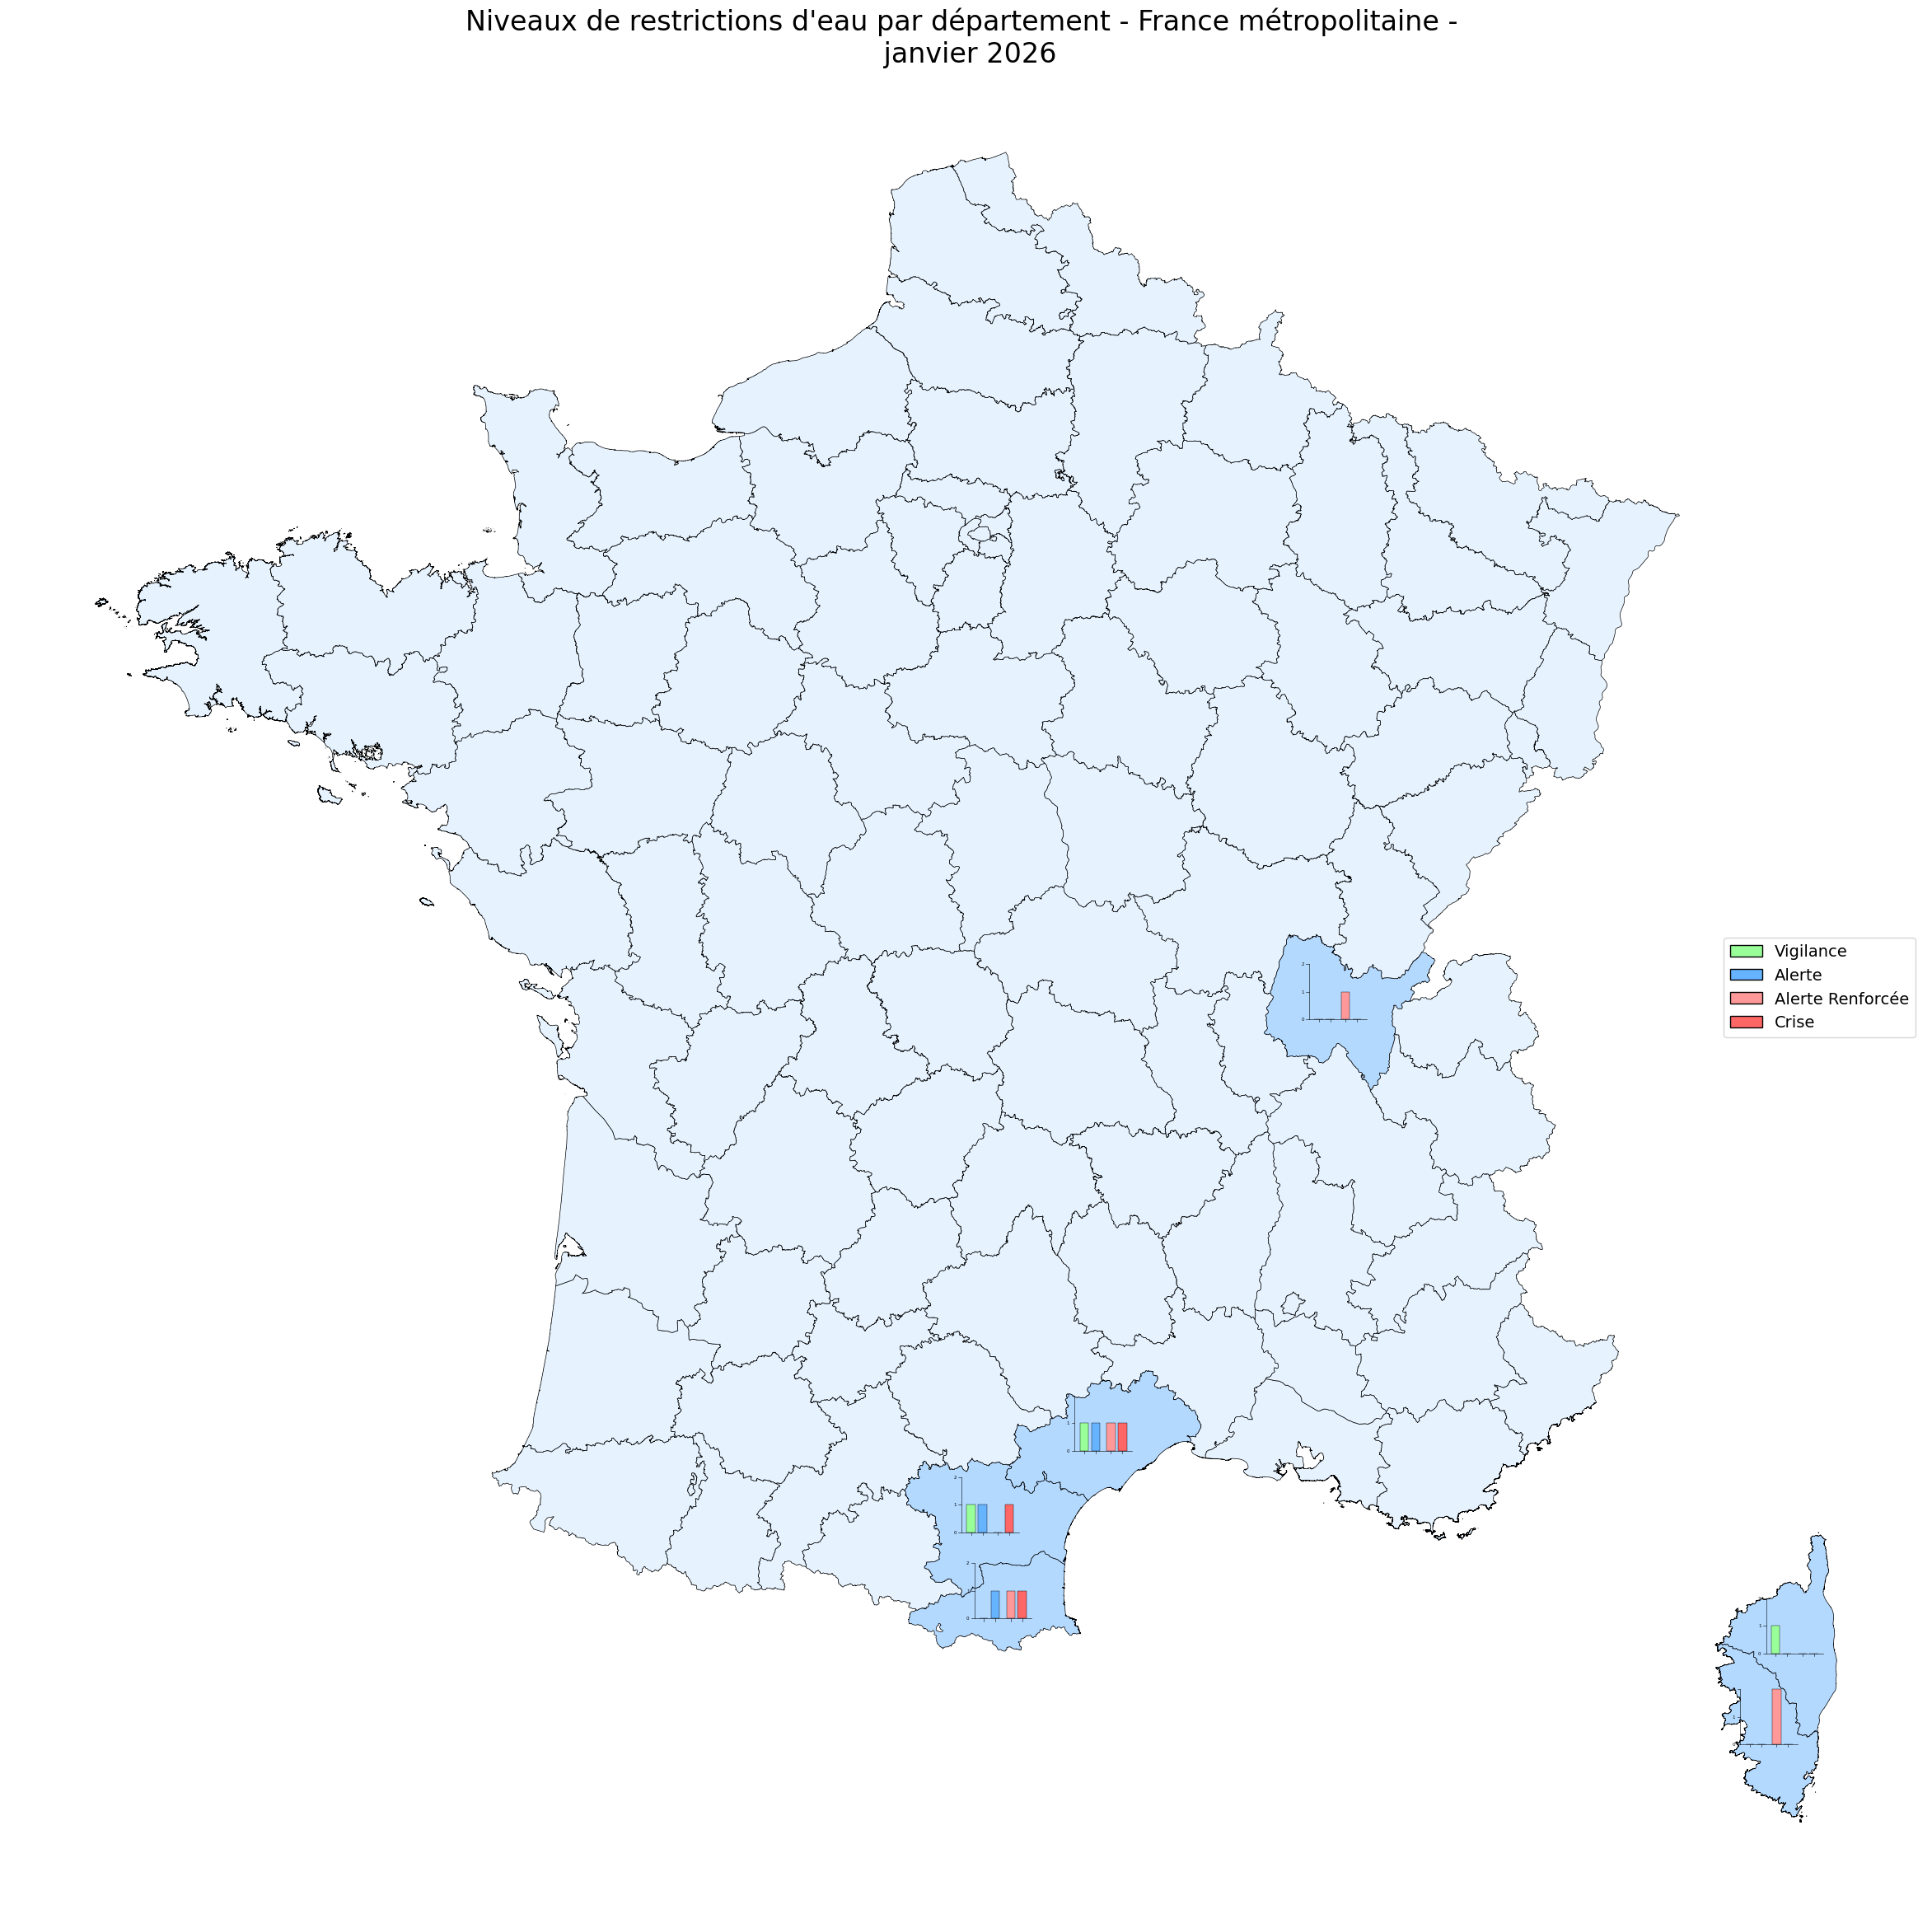

In [161]:
create_bar_chart_map(metropole_gdf, mois=1, annee=2026)

In [ ]:
def create_gradient_map(data, mois, annee):
    mois_name = datetime(annee, mois, 1).strftime('%B')
    
    fig, ax = plt.subplots(figsize=(30, 30))
    
    # Couleurs pour chaque niveau
    colors = {
        'vigilance': '#99ff99',
        'alerte': '#66b3ff',
        'alerte_renforcee': '#ff9999',
        'crise': '#ff6666'
    }
    
    # D'abord tracer tous les départements en blanc/gris clair
    metropole_gdf.plot(ax=ax, color='#f0f0f0', edgecolor='black', linewidth=0.5)
    
    # Pour chaque département avec données
    for idx, row in metropole_gdf.iterrows():
        values = {
            'vigilance': row['vigilance'],
            'alerte': row['alerte'],
            'alerte_renforcee': row['alerte_renforcee'],
            'crise': row['crise']
        }
        
        # Vérifier s'il y a des données
        if all(pd.isna(v) for v in values.values()):
            continue
        
        # Remplacer NaN par 0
        values = {k: (v if not pd.isna(v) else 0) for k, v in values.items()}
        total = sum(values.values())
        
        if total == 0:
            continue
        
        # Obtenir la géométrie du département
        geom = row.geometry
        bounds = geom.bounds  # (minx, miny, maxx, maxy)
        
        # Créer des bandes horizontales pour chaque niveau
        current_y = bounds[1]  # Partir du bas
        height = bounds[3] - bounds[1]
        
        # Ordre d'empilement (du bas vers le haut)
        ordre = ['vigilance', 'alerte', 'alerte_renforcee', 'crise']
        
        for niveau in ordre:
            if values[niveau] > 0:
                proportion = values[niveau] / total
                band_height = height * proportion
                
                # Créer un rectangle pour cette bande
                from shapely.geometry import box
                band = box(bounds[0], current_y, bounds[2], current_y + band_height)
                
                # Intersection avec la géométrie du département
                clipped = geom.intersection(band)
                
                # Tracer cette portion
                if not clipped.is_empty:
                    gpd.GeoSeries([clipped]).plot(
                        ax=ax, 
                        color=colors[niveau], 
                        edgecolor='none'
                    )
                
                current_y += band_height
    
    # Retracer les contours des départements par-dessus
    metropole_gdf.boundary.plot(ax=ax, edgecolor='black', linewidth=0.5)
    
    # Légende
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#99ff99', edgecolor='black', label='Vigilance'),
        Patch(facecolor='#66b3ff', edgecolor='black', label='Alerte'),
        Patch(facecolor='#ff9999', edgecolor='black', label='Alerte Renforcée'),
        Patch(facecolor='#ff6666', edgecolor='black', label='Crise')
    ]
    ax.legend(handles=legend_elements, fontsize=14, loc='right')
    
    plt.title(f"Niveaux de restrictions d'eau par département - France métropolitaine\n{mois_name} {annee}", 
              fontsize=24)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(f'carte_departements_gradient_{mois}_{annee}.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

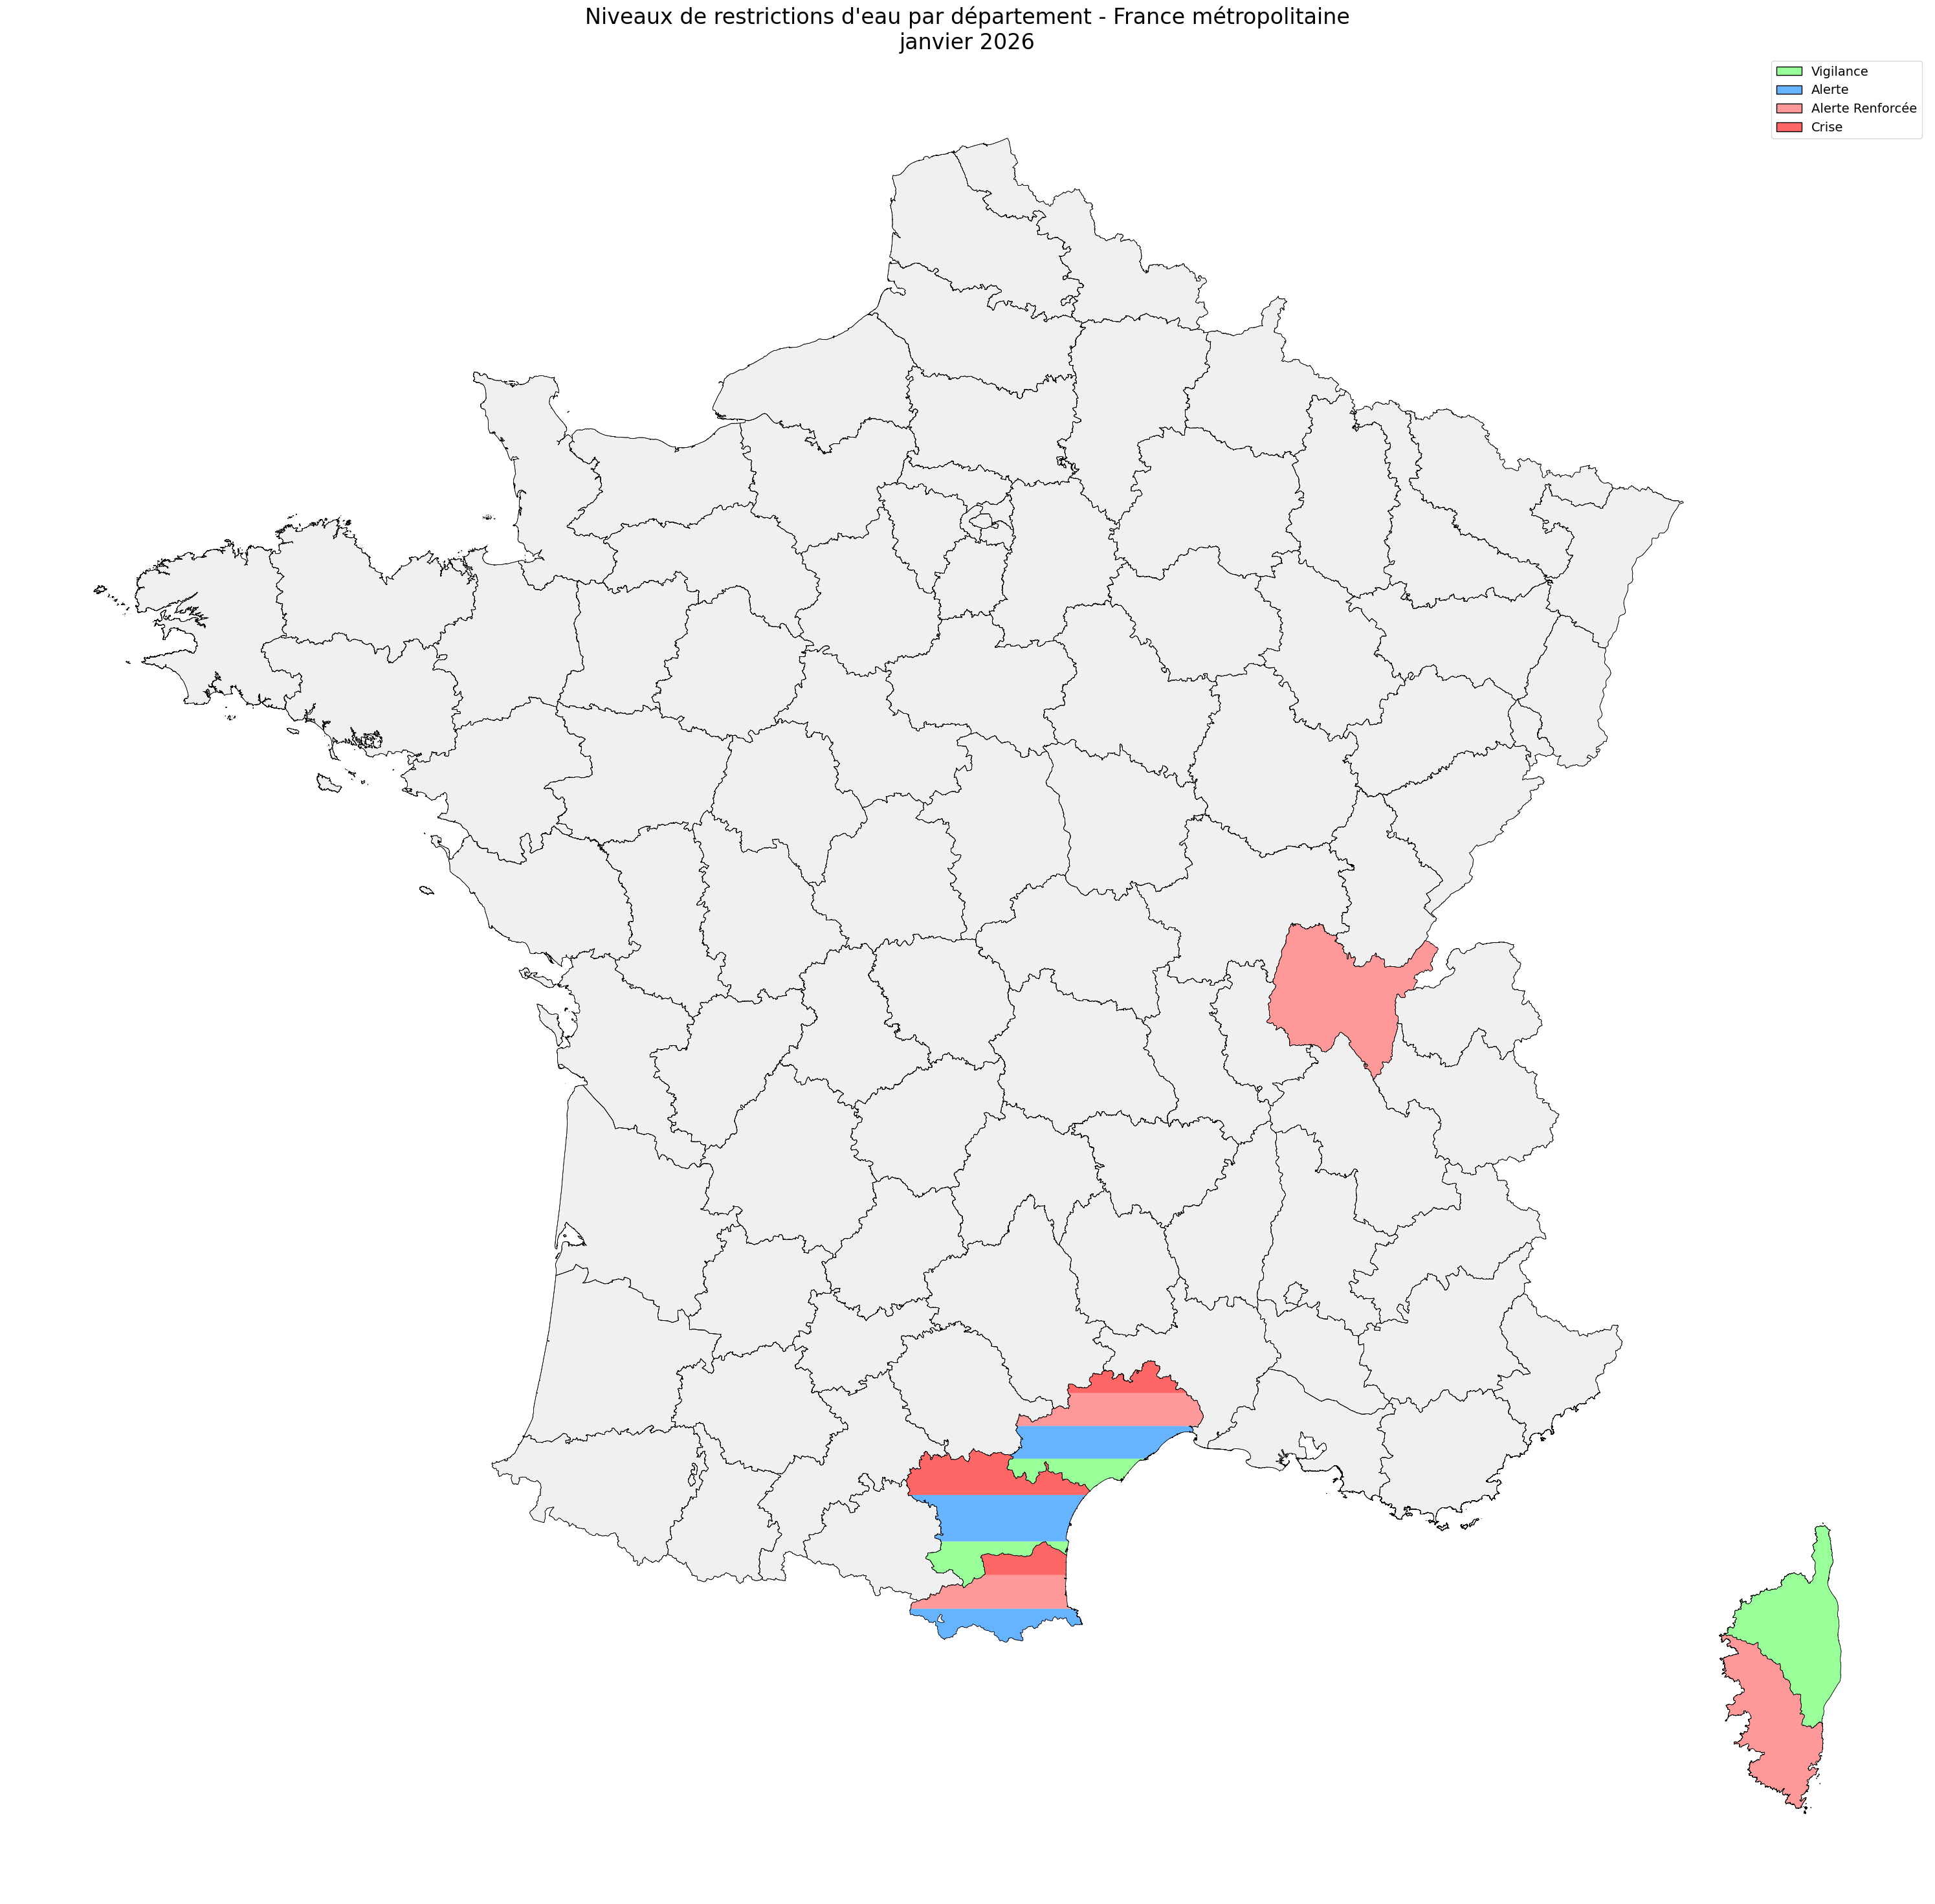

In [174]:
create_gradient_map(metropole_gdf, mois=1, annee=2026)